In [4]:
"""
Created on Wed Oct 12 14:29:55 2022

@author: oliver
"""

import numpy as np
import random
from matplotlib import pyplot as plt
from itertools import count
import time

from kyoka.task import BaseTask
from kyoka.algorithm.sarsa import SarsaTabularActionValueFunction
from kyoka.callback import BasePerformanceWatcher
from kyoka.algorithm.sarsa import Sarsa
from kyoka.policy import EpsilonGreedyPolicy
from kyoka.callback import BaseCallback
from kyoka.policy import choose_best_action


class Minirace(BaseCallback):

    def __init__(self, level=1, size=6, normalise=False):
        # level is the dimensionality of state vector (1 or 2)
        self.level = min(2, max(1, level))  
        # size is the number of track positions (every 2 pixels, from 1..n-1).
        # this means there are 2 more car positions (0 and n)s
        self.size = max(3, size)
        self.xymax = 2 * (self.size + 2)  # 16
        # whether to normalise the state representation
        self.scale = 2 if normalise and level > 1 else 1.0

        # the internal state is s1 = (x, z, d). Previous internal state in s0.
        # x: x-coordinate of the car
        # z[]: x-coordinate of the track, one for each y-coordinate
        # d[]: dx for the track, for each y-coordinate(dx:the relative position of the middle of the track right in front of the car)
        self.generate_initial_state()

    def observationspace(self):
        """
        Dimensionality of the observation space

        Returns
        -------
        int
            Number of values return as an observation.

        """
        return self.level

    def nexttrack(self, z, d=2):
        """
        Move the next piece of track based on coordinate z, and curvature

        Parameters
        ----------
        z : int
            x-coordinate for the previous track segment.
        d : int, optional
            previous "curvature" (change of coordinate). The default is 2.
            This is to prevent too strong curvature (car can only move 1 step)

        Returns
        -------
        znext : int
            The x-coordinate for the next piece of track (middle of the track).
        dz : int
            The change compared to the previous coordinate (-2..2).

        """
        trackd = random.randint(-2, 2)
        if self.level == 1 or abs(d) > 1:
            trackd = min(1, max(-1, trackd))  

        znext = max(1, min(self.size, z + trackd)) 
        dz = znext - z
        return znext, dz

    def state(self):
        """
        Returns the (observed) state of the system.

        Depending on level, the observed state is an
        array of 1 to 5 values, or a pixel representation (level 0).

        Returns
        -------
        np.array
            level 1: [dx]
                 dx: relative distance in x-coordinate between car and next
                     piece of track (the one in front of the car).
                     May be normalised to values between -1 and 1,
                     depending on initialisation.
        """
        x, z, d = self.s1
        # print("self.s1:", self.s1)
        ## level 1:
        # return the difference between car x and the next piece of track
        if self.level == 1:
            return np.array([(z[2] - x) / self.scale])
        if self.level == 2:
            return np.array([(z[2] - x) / self.scale, (z[3] - z[2]) / self.scale])

        raise ValueError("level not implemented")

    def transit_state(self, state, action=0):
        """
        Apply an action and update the environment.
        0: do nothing
        1: move left
        2: move right

        Parameters
        ----------
        action : int, optional
            The action applied before the update.
            The default is 0 (representing no action).

        Returns
        -------
        np.array
            The new observed state of the environment.

        """
        self.s0 = self.s1

        # state = self.state()
        if self.is_terminal_state(state):
            return self.state()

        x0, z0, d0 = self.s0
        z1 = np.roll(z0, -1)  
        d1 = np.roll(d0, -1)

        x1 = x0
        if action == 1:
            x1 = max(0, x0 - 1)
        elif action == 2:
            x1 = min(self.size - 1, x0 + 1)  # 0<= x <=5

        z1[-1], d1[-1] = self.nexttrack(z0[-1], d0[-1])
        self.s1 = (x1, z1, d1)
        return self.state()

    def generate_possible_actions(self, state):
        return [0, 1, 2]

    def is_terminal_state(self, state):
        """
        Check if episode is finished.

        Returns
        -------
        bool
            True if episode is finished.

        """
        x, z, _ = self.s1

        return abs(z[1] - x) > 1.0  # 0 +1 -1 which mean [car in middle of the track, car in left of the track, car in right of the track]

    def calculate_reward(self, state):
        """
        Calculate immediate reward.
        Positive reward for staying on track.

        Parameters
        ----------
        action : int
            0-2, for the 3 possible actions.

        Returns
        -------
        r : float
            immediate reward.

        """
        r = 1.0 if not self.is_terminal_state(state) else 0.0

        return r

    def step(self, action):
        # return tuple (state, reward, done)
        cur_state = self.state()
        state = self.transit_state(cur_state, action)
        r = self.calculate_reward(state)
        done = self.is_terminal_state(state)
        return (state, r, done)

    def generate_initial_state(self):
        # the internal state is
        # x: x-coordinate of the car  
        # z[]: x-coordinate of the track, one for each y-coordinate  
        # d[]: dx for the track, for each y-coordinate   
        x = random.randint(0, self.size - 1)  # [0, self.size-1]
        z = np.zeros(self.xymax)
        d = np.zeros(self.xymax)
        z[0] = max(1, min(self.size, x))
        z[1] = z[0]  
        d[1] = 2  
        for i in range(2, self.xymax):
            z[i], d[i] = self.nexttrack(z[i - 1], d[i - 1])

        self.s0 = (x, z, d)
        self.s1 = (x, z, d)
        '''
        print("self.s0:", self.s0)
        print("self.s1:", self.s1)
        self.render()
        '''
        return self.state()

    def sampleaction(self):  # random strategy
        # return a random action [0,2]
        action = random.randint(0, 2)
        return action

    def render(self, text=True, reward=None, cm=plt.cm.bone_r, f=None):  
        x, z, _ = self.s1
        pix = self.to_pix(x, z, text)
        if text:
            if reward is not None:
                print('{:.3f}'.format(reward))
            print(''.join(np.flip(pix, axis=0).ravel()))
        else:
            fig, ax = plt.subplots()
            if reward is not None:
                plt.title(f'Reward: {reward}', loc='right')
            ax.axis("off")
            plt.imshow(pix, origin='lower', cmap=cm)
            if f is not None:
                plt.savefig(f, dpi=300)
            plt.show()

    def to_pix(self, x, z, text=False):  
        """
        Generate a picture from an internal state representation

        Parameters
        ----------
        x : int
            car x-coordinate
        z : np.array
            array with track coordinates
        text : bool, optional
            flag if generate text represenation

        Raises
        ------
        ValueError
            If x,y,z are outside their range.

        Returns
        -------
        image : np.array
            a square image with pixel values 0, 0.5, and 1.

        """
        if x < 0 or x > self.size + 1:
            raise ValueError('car coordinate value error')
        if np.min(z) < 1 or np.max(z) > self.size:
            raise ValueError('track coordinate value error')

        car = '#' if text else 2

        if text:
            image = np.array(list(':' * (self.xymax + 1)) * (self.xymax)).reshape(self.xymax, -1)
            image[:, -1] = '\n'
        else:
            image = np.ones((self.xymax, self.xymax), dtype=int)

        for i, j in enumerate(z):
            j = int(j * 2)
            image[i, j - 2:j + 4] = ' ' if text else 0

        image[0:2, 2 * x:(2 * x + 2)] = car

        return image

    def state_based_action(self, state):
        if self.level == 1:  # no normalization
            if state >= 1:
                action = 2  # car turn right
            elif state == 0:
                action = 0
            elif state <= -1:
                action = 1  # car turn left
        return action





In [5]:

class MazeTabularValueFunction(SarsaTabularActionValueFunction):

    def generate_initial_table(self):
        state_num, action_num = 13, 3
        table = [[0 for a in range(action_num)] for j in range(state_num)]  # 13*4
        '''
        table = [[0, 1, -1], [0, 1, -1], [0, 1, -1], [0, 1, -1], [0, 1, -1], [0.5, 1, -1], [1, 0.5, 0.5], [0.5, -1, 1],
                 [0, -1, 1], [0, -1, 1], [0, -1, 1], [0, -1, 1], [0, -1, 1]]
                 '''
        return table

    def fetch_value_from_table(self, table, state, action):
        # print("state:", state)
        return table[int(state) + 6][action]

    def insert_value_into_table(self, table, state, action, new_value):
        table[int(state) + 6][action] = new_value


class MazeTransformationCallback(BaseCallback):

    def after_update(self, iteration_count, therace, value_function):
        if 50 == iteration_count:
            therace.generate_initial_state()
            # we recommend you to use "self.log(message)" instead of "print" method in callback.
            self.log("Maze transformed after %d iteration." % iteration_count)




def mypolicy_v0(state):
    action = therace.sampleaction()
    return action


def mypolicy(state):
    # selecting actions based on the state information
    action = therace.state_based_action(state)
    return action

State-Action ValueTable(initial) [[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0]]
[Progress] Start GPI iteration for 100 times
[EpsilonGreedyAnnealing] Anneal epsilon from 1 to 0.01.
[Progress] Finished 1 / 100 iterations (0.0s)
[EpsilonGreedyAnnealing] Annealing has finished at 1 iteration.
[Progress] Finished 2 / 100 iterations (0.0s)
[Progress] Finished 3 / 100 iterations (0.0s)
[Progress] Finished 4 / 100 iterations (0.0s)
[Progress] Finished 5 / 100 iterations (0.0s)
[Progress] Finished 6 / 100 iterations (0.0s)
[Progress] Finished 7 / 100 iterations (0.0s)
[Progress] Finished 8 / 100 iterations (0.0s)
[Progress] Finished 9 / 100 iterations (0.0s)
[Progress] Finished 10 / 100 iterations (0.0s)
[Progress] Finished 11 / 100 iterations (0.0s)
[Progress] Finished 12 / 100 iterations (0.0s)
[Progress] Finished 13 / 100 iterations (0.0s)
[Progress] Finished 14 / 100 iterations (0.0s)
[Progress

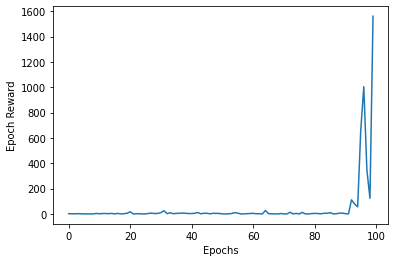

State-Action ValueTable(final): [[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0.0, 43.40089126040047, 0.0], [49.3706267451947, 6.0031920285251275, 0.0], [49.66251188412054, 2.1747550703153897, 11.20955889950081], [49.562313541449164, 0.25079573093430796, 9.99189317156236], [0.0, 0.0, 48.09937112921078], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0]]
Episode 0	 Last reward: 10000.00
Episode 1	 Last reward: 10000.00
Episode 2	 Last reward: 10000.00
Episode 3	 Last reward: 10000.00
Episode 4	 Last reward: 10000.00
Episode 5	 Last reward: 10000.00
Episode 6	 Last reward: 10000.00
Episode 7	 Last reward: 10000.00
Episode 8	 Last reward: 10000.00
Episode 9	 Last reward: 10000.00
Episode 10	 Last reward: 10000.00
Episode 11	 Last reward: 10000.00
Episode 12	 Last reward: 10000.00
Episode 13	 Last reward: 10000.00
Episode 14	 Last reward: 10000.00
Episode 15	 Last reward: 10000.00
Episode 16	 Last reward: 10000.00
Episode 17	 Last reward: 10000.00
Episode 18	 Last reward: 10000.00
Episode 19	 Las

In [6]:
if __name__ == "__main__":
    # parameter
    seed = 1
    gamma = 0.99
    render = True
    finalrender = True
    log_interval = 1  # 100
    render_interval = 1  # 1000
    running_reward = 0


    

    # train
    therace = Minirace(level=1, size=6)
    policy = EpsilonGreedyPolicy(eps=1)
    policy.set_eps_annealing(initial_eps=1, final_eps=0.01, anneal_duration=0.01)
    value_function = MazeTabularValueFunction()
    algorithm = Sarsa(gamma=gamma) #by default: alpha = 0.1 gamma = 0.9
    algorithm.setup(therace, policy, value_function)
    #callbacks = [MazeTransformationCallback(), MazePerformanceWatcher()]

    
    # print initial State-Action ValueTable
    actions = [0, 1, 2]
    Q_value_for_actions = [[value_function.predict_value(state, action) for action in actions] for state in range(-6, 7)]
    print("State-Action ValueTable(initial)", Q_value_for_actions)

    train_ep_reward = algorithm.run_gpi(nb_iteration=100)

    


    # visualizatino
    plt.ion()
    fig = plt.figure()
    plt.plot(train_ep_reward)
    plt.xlabel('Epochs')
    plt.ylabel('Epoch Reward')
    plt.show()


    # print final State-Action ValueTable
    actions = [0, 1, 2]
    Q_value_for_actions = [[value_function.predict_value(state, action) for action in actions] for state in range(-6, 7)]
    print("State-Action ValueTable(final):", Q_value_for_actions)
    





    '''
    # Random strategies test 
    random_reward_list = []
    for i_episode in range(50): 
        state, ep_reward, done = therace.generate_initial_state(), 0, False
        for t in range(0,10000):  # Don't infinite loop while learning
            #action = choose_best_action(therace, value_function, state)
            action = mypolicy_v0(state)
            state, reward, done = therace.step(action) 
            reward = float(reward)  # strange things happen if reward is an int
            ep_reward += reward
            if done:
                break
        random_reward_list.append(ep_reward)
        print('Episode {}\t Last reward: {:.2f}'.format(i_episode, ep_reward))

    a_mean = np.mean(random_reward_list)
    a_std = np.std(random_reward_list, ddof=1)
    print("****************************Random strategies*************************")
    print("test 500 episode max_step=10000 mean=%f" % a_mean)
    print("test 500 episode max_step==10000 standard_deviation=%f" % a_std)
    print("**********************************************************************")
    '''

    # Reinforcement learning strategies test 
    reward_list = []
    for i_episode in range(50): 
        state, ep_reward, done = therace.generate_initial_state(), 0, False
        for t in range(0,10000):  # Don't infinite loop while learning
            action = choose_best_action(therace, value_function, state)
            #action = mypolicy(state)
            state, reward, done = therace.step(action) 
            reward = float(reward)  # strange things happen if reward is an int
            ep_reward += reward
            if done:
                break
        reward_list.append(ep_reward)
        print('Episode {}\t Last reward: {:.2f}'.format(i_episode, ep_reward))

    a_mean = np.mean(reward_list)
    a_std = np.std(reward_list, ddof=1)
    print("****************************Reinforcement learning strategies*************************")
    print("test 500 episode max_step=10000 mean=%f" % a_mean)
    print("test 500 episode max_step==10000 standard_deviation=%f" % a_std)
    print("**********************************************************************")


